In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import jax
import znnl
from neural_tangents import stax
import copy
import optax

from flax import linen as nn
import flax
import jax.nn.initializers as inits

import matplotlib.pyplot as plt

import numpy as onp
import jax.numpy as np
# import time

2023-10-03 14:12:49.333240: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-10-03 14:12:51.662550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using backend: cpu

Available hardware:

TFRT_CPU_0

# Including the trace regularization

In [2]:
# from flax.training.train_state import TrainState
# from znnl.training_strategies import SimpleTraining
# from typing import Callable, List, Optional, Tuple, Union
# from znnl.accuracy_functions.accuracy_function import AccuracyFunction
# from znnl.models.jax_model import JaxModel
# from znnl.training_strategies.recursive_mode import RecursiveMode

## Code with Regularizer class

In [12]:
from abc import ABC
from znnl.regularizers import Regularizer

In [ ]:
# class Regularizer(ABC):
#     """
#     Parent class for all regularizers.
#     """

#     def __init__(self, reg_factor) -> None:
#         """
#         Constructor of the regularizer class.

#         Parameters
#         ----------
#         reg_factor : float
#                 Regularization factor.
#         """
#         self.reg_factor = reg_factor
    
#     def __call__(self, apply_fn, params, batch):
#         """
#         Call function of the regularizer class.

#         Parameters
#         ----------
#         params : dict
#                 Parameters of the model.

#         Returns
#         -------
#         reg_loss : float
#                 Regularization loss.
#         """
#         raise NotImplementedError
    

# class TraceRegularizer(Regularizer):
#     """
#     Trace regularizer class.

#     Regularizing gradient based learning with proportional to the trace of the NTK.
#     As the trace of the NTK is calculated from the gradients of the model, the
#     regularizer is implemented as a function of the gradients.
#     """

#     def __init__(self, reg_factor) -> None:
#         super().__init__(reg_factor)    
#         self._jit_grad_helper_fn = jax.jit(self.grad_helper_fn)
    
#     @staticmethod
#     def grad_helper_fn(params, apply_fn, input_point):
#         """
#         Helper function for the gradient computation.
#         """
#         # out = apply_fn(params, input_point)
#         out = apply_fn(params, np.expand_dims(input_point, axis=0))
#         print(out.shape)
#         return out.sum()

# #     @jax.jit
#     def __call__(self, apply_fn, params, batch):
#         """
#         Call function of the trace regularizer class.

#         Parameters
#         ----------
#         grads : dict
#                 Gradients of the model.

#         Returns
#         -------
#         reg_loss : float
#                 Regularization loss.
#         """

#         def grad_helper_fn(params):
#             """
#             Helper function for the gradient computation.

#             Returns
#             -------
#             params : dict
#                     Parameters of the model.
#             """
#             traced_predictions = apply_fn(params, batch["inputs"])
#             return traced_predictions

#         # # Compute gradient of shape=(batch_size, n_outputs, params)
#         # grad = jax.jacrev(grad_helper_fn)(params)
#         # # Compute squared gradient of shape=(batch_size, n_outputs, params)
#         # grad_square = jax.tree_util.tree_map(lambda x: x ** 2, grad)
#         # # # Average over all axes except the batch axis.
#         # # idx_tree = jax.tree_util.tree_map(lambda x: tuple(range(1, len(x.shape))), grad_square)
#         # # grad_sum = jax.tree_util.tree_map(lambda x, y: np.mean(x, axis=y), grad_square, idx_tree)
#         # # # Add regularization term to loss.
#         # # reg_loss = self.reg_factor * jax.flatten_util.ravel_pytree(grad_sum)[0].mean()

#         # squared_grads = jax.flatten_util.ravel_pytree(grad_square)[0] 
#         # reg_loss = self.reg_factor * squared_grads.mean()

#         # return reg_loss


#         grads = jax.jacrev(apply_fn)(params, batch["inputs"])
        
#         # Compute squared gradient of shape=(batch_size, n_outputs, params)
#         squared_grads = jax.flatten_util.ravel_pytree(grads)[0] ** 2
#         reg_loss = self.reg_factor * squared_grads.mean()
#         return reg_loss


# class GradRegularizer(Regularizer):
#     """
#     Grad regularizer class.

#     Regularizing gradient based learning with proportional to the gradient of each 
#     sample.
#     """
#     def __init__(self, reg_factor) -> None:
#         super().__init__(reg_factor)    
    
#     def __call__(self, apply_fn, params, batch):
#         """
#         Call function of the trace regularizer class.

#         Parameters
#         ----------
#         grads : dict
#                 Gradients of the model.

#         Returns
#         -------
#         reg_loss : float
#                 Regularization loss.
#         """

#         def grad_helper_fn(params):
#             """
#             helper grad computation

#             Returns
#             -------
#             ntk_trace_values : float, shape=(batch_size,)
#                     Model predictions, averaged over the output dimension.
#             """
#             averaged_predictions = apply_fn(params, batch["inputs"]).mean()
#             return averaged_predictions  

#         # Compute gradient of shape=(batch_size, n_outputs, params)
#         grad = jax.grad(grad_helper_fn)(params)
#         # Compute squared gradient of shape=(batch_size, n_outputs, params)
#         grad_sum = jax.tree_util.tree_map(lambda x: np.mean(x ** 2), grad)
#         reg_loss = self.reg_factor * jax.flatten_util.ravel_pytree(grad_sum)[0].mean()
#         return reg_loss


# class NormRegularizer(Regularizer):
#     """
#     Class to regularize on the norm of the parameters.

#     Regularizing training using the norm of the parameters.
#     Any function can be used that takes the parameters as input and returns a scalar.
#     """
#     def __init__(self, reg_factor: float = 1e-2, norm_fn: Optional[Callable] = None) -> None:
#         """
#         Constructor of the regularizer class.

#         Parameters
#         ----------
#         reg_factor : float
#                 Regularization factor.
#         norm_fn : Callable
#                 Function to compute the norm of the parameters.
#         """
#         super().__init__(reg_factor)
#         self.norm_fn = norm_fn
#         if self.norm_fn is None:
#             self.norm_fn = lambda x: np.mean(x ** 2)
    
#     def __call__(self, apply_fn, params, batch):
#         """
#         Call function of the trace regularizer class.

#         Parameters
#         ----------
#         grads : dict
#                 Gradients of the model.

#         Returns
#         -------
#         reg_loss : float
#                 Regularization loss.
#         """
#         # Compute squared gradient of shape=(batch_size, n_outputs, params)
#         param_average = jax.tree_util.tree_map(lambda x: self.norm_fn(x), params)
#         reg_loss = self.reg_factor * jax.flatten_util.ravel_pytree(param_average)[0].mean()
#         return reg_loss

In [ ]:
# from znnl.regularizers import Regularizer

# class RegularizedTraining(SimpleTraining):

#     def __init__(
#         self,
#         model: Union[JaxModel, None],
#         loss_fn: Callable,
#         accuracy_fn: AccuracyFunction = None,
#         seed: int = None,
#         recursive_mode: RecursiveMode = None,
#         disable_loading_bar: bool = False,
#         recorders: List["JaxRecorder"] = None,
#         regulizer: Regularizer = None,
#     ):
#         """
#         Construct a simple training strategy for a model.

#         Parameters
#         ----------
#         model : Union[JaxModel, None]
#                 Model class for a Jax model.
#                 "None" is only used if the training strategy is passed as an input
#                 to a bigger framework. The strategy then is applied to the framework
#                 and the model instantiation is handled by that framework.
#         loss_fn : Callable
#                 A function to use in the loss computation.
#         accuracy_fn : AccuracyFunction (default = None)
#                 Funktion class for computing the accuracy of model and given data.
#         seed : int (default = None)
#                 Random seed for the RNG. Uses a random int if not specified.
#         recursive_mode : RecursiveMode
#                 Defining the recursive mode that can be used in training.
#                 If the recursive mode is used, the training will be performed until a
#                 condition is fulfilled.
#         disable_loading_bar : bool
#                 Disable the output visualization of the loading bar.
#         recorders : List[JaxRecorder]
#                 A list of recorders to monitor model training.
#         regularizer : Regularizer
#                 Regularizer class for including a regularizer in the training.
#         """
#         super().__init__(
#             model=model,
#             loss_fn=loss_fn,
#             accuracy_fn=accuracy_fn,
#             seed=seed,
#             recursive_mode=recursive_mode,
#             disable_loading_bar=disable_loading_bar,
#             recorders=recorders,
#         )
#         self.regularizer = regulizer
#         if self.regularizer:
#                 regulizer.__call__ = jax.jit(regulizer.__call__)

                
#     def _train_step(self, state: TrainState, batch: dict):
#         """
#         Train a single step.

#         Parameters
#         ----------
#         state : TrainState
#                 Current state of the neural network.
#         batch : dict
#                 Batch of data to train on.

#         Returns
#         -------
#         state : dict
#                 Updated state of the neural network.
#         metrics : dict
#                 Metrics for the current model.
#         """

#         def loss_fn(params):
#             """
#             helper loss computation
#             """
#             inner_predictions = self.model.apply(params, batch["inputs"])
#             loss = self.loss_fn(inner_predictions, batch["targets"])

#             # Add gradient regularization
#             if self.regularizer:
#                 reg_loss = self.regularizer(
#                     apply_fn=self.model.apply, 
#                     params=params, 
#                     batch=batch, 
#                 )
#                 loss += reg_loss
#             return loss, inner_predictions
        
#         grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

#         (_, predictions), grads = grad_fn(state.params)

#         state = state.apply_gradients(grads=grads)  # in place state update.
#         metrics = self._compute_metrics(
#             predictions=predictions, targets=batch["targets"]
#         )

#         return state, metrics

# Set up Model

In [3]:
data_generator = znnl.data.MNISTGenerator(ds_size=50)

2023-10-03 14:12:55.737167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
class Network(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):        
        x = x.reshape((x.shape[0], -1))  # flatten
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

In [5]:
model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.01),
        input_shape=(1, 28, 28, 1),
        seed=0, 
    )

train_recorder = znnl.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    ntk=True,
    entropy= True, 
    trace=True,
    loss_derivative=True,
    update_rate=1, 
    chunk_size=1000
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)


test_recorder = znnl.training_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    update_rate=1,
    chunk_size=1000
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

# Execute training

In [6]:
from znnl.regularizers import TraceRegularizer, NormRegularizer
from znnl.training_strategies import SimpleTraining

In [7]:
loss_fn = znnl.loss_functions.CrossEntropyLoss(),

def reg_schedule_fn(epoch, reg_factor):
    return reg_factor * 0.9 ** epoch

regularizer = NormRegularizer(reg_factor=1e-2, reg_schedule_fn=reg_schedule_fn)

In [8]:
trainer = SimpleTraining(
    model=model, 
    loss_fn=znnl.loss_functions.CrossEntropyLoss(),
    accuracy_fn=znnl.accuracy_functions.LabelAccuracy(), 
    recorders=[train_recorder, test_recorder],  
    regularizer=regularizer,
    seed=0
)

In [9]:
batched_training_metrics = trainer.train_model(
    train_ds=data_generator.train_ds, 
    test_ds=data_generator.test_ds,
    batch_size=32,
    epochs=100,
)

  0%|                                                                    | 0/100 [00:00<?, ?batch/s]

Epoch: 100: 100%|████████████████████████████████| 100/100 [00:21<00:00,  4.62batch/s, accuracy=0.6]


In [10]:
train_report = train_recorder.gather_recording()
test_report = test_recorder.gather_recording()

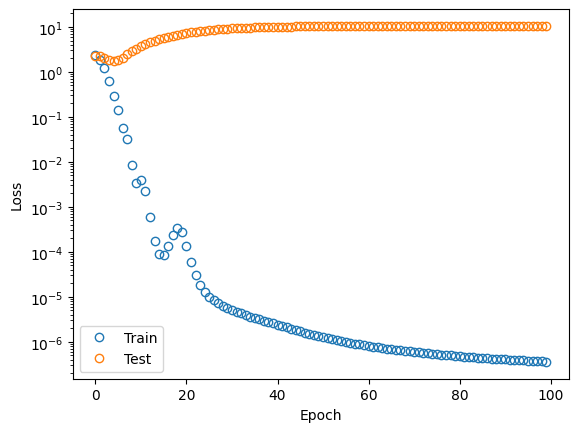

In [11]:
plt.plot(train_report.loss, 'o', mfc='None', label="Train")
plt.plot(test_report.loss, 'o', mfc='None', label="Test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

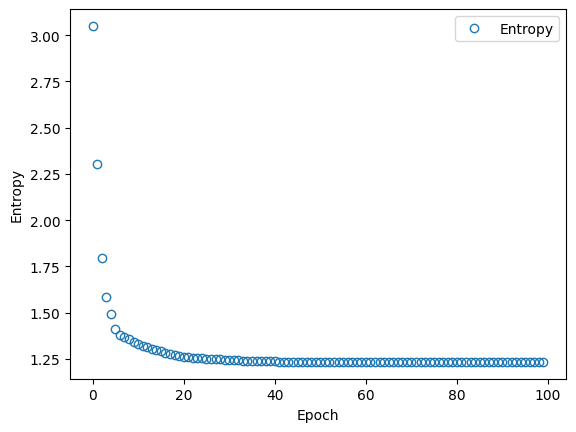

In [12]:
plt.plot(train_report.entropy, 'o', mfc='None', label="Entropy")
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.legend()
plt.show()

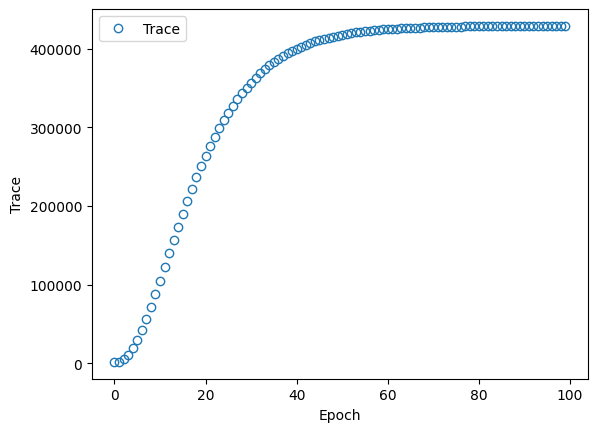

In [13]:
plt.plot(train_report.trace, 'o', mfc='None', label="Trace")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.legend()
plt.show()

# Perform quick study

In [16]:
from znnl.regularizers import TraceRegularizer, NormRegularizer, Regularizer
from znnl.training_strategies import SimpleTraining

In [31]:
def perform_quick_study(regularizer: Regularizer):

    model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.01),
        input_shape=(1, 28, 28, 1),
        seed=0, 
    )

    train_recorder = znnl.training_recording.JaxRecorder(
        name="train_recorder",
        loss=True,
        ntk=True,
        entropy= True, 
        trace=True,
        loss_derivative=True,
        update_rate=1, 
        chunk_size=1000
    )
    train_recorder.instantiate_recorder(
        data_set=data_generator.train_ds
    )


    test_recorder = znnl.training_recording.JaxRecorder(
        name="test_recorder",
        loss=True,
        accuracy=True,
        update_rate=1,
        chunk_size=1000
    )
    test_recorder.instantiate_recorder(
        data_set=data_generator.test_ds
    )

    trainer = SimpleTraining(
        model=model, 
        loss_fn=znnl.loss_functions.CrossEntropyLoss(),
        accuracy_fn=znnl.accuracy_functions.LabelAccuracy(), 
        recorders=[train_recorder, test_recorder],  
        regularizer=regularizer, 
        seed=0
    )

    batched_training_metrics = trainer.train_model(
        train_ds=data_generator.train_ds, 
        test_ds=data_generator.test_ds,
        batch_size=32,
        epochs=100,
    )

    train_report = train_recorder.gather_recording()
    test_report = test_recorder.gather_recording()

    return train_report, test_report

In [32]:
regularizers = [
    NormRegularizer(reg_factor=1e1),
    TraceRegularizer(reg_factor=5e-1),
]

In [33]:
# Execute a quick study
train_report_norm, test_report_norm = perform_quick_study(regularizers[0])
train_report_trace, test_report_trace = perform_quick_study(regularizers[1])

  0%|                                                                    | 0/100 [00:00<?, ?batch/s]

Epoch: 100: 100%|████████████████████████████████| 100/100 [01:32<00:00,  1.08batch/s, accuracy=0.6]


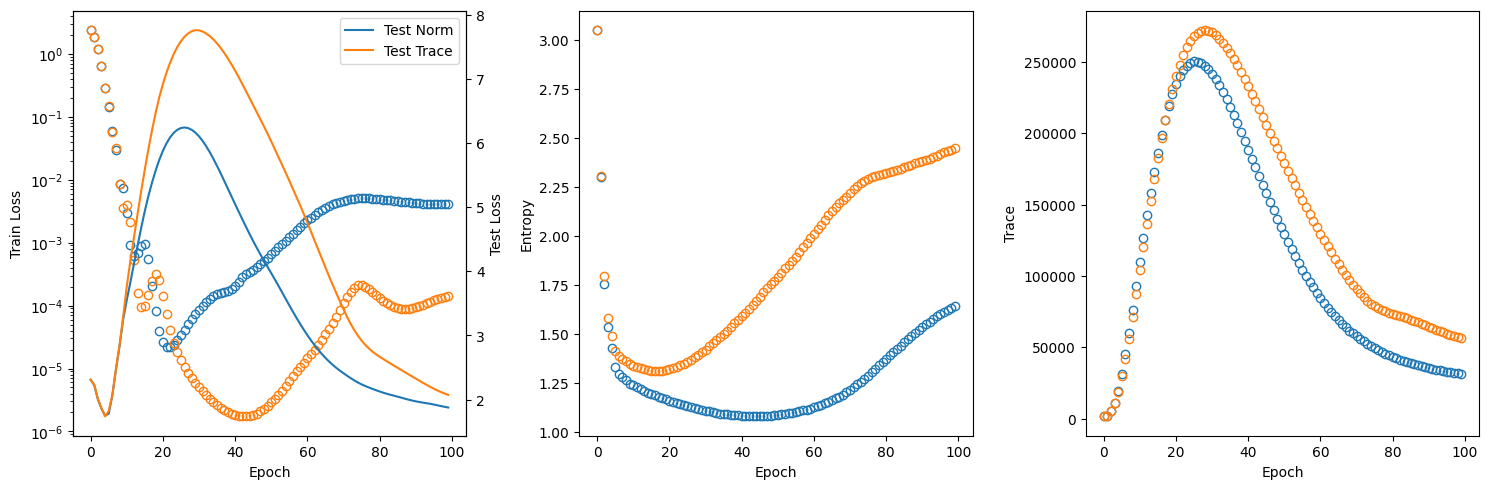

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

axs[0].plot(train_report_norm.loss, 'o', mfc='None', label="Train Norm")
axs[0].plot(train_report_trace.loss, 'o', mfc='None', label="Train Trace")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[0].set_yscale("log")

axs_twinx = axs[0].twinx()
axs_twinx.plot(test_report_norm.loss, '-', mfc='None', label="Test Norm")
axs_twinx.plot(test_report_trace.loss, '-', mfc='None', label="Test Trace")
axs_twinx.set_ylabel("Test Loss")

axs[1].plot(train_report_norm.entropy, 'o', mfc='None', label="Norm")
axs[1].plot(train_report_trace.entropy, 'o', mfc='None', label="Trace")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Entropy")

axs[2].plot(train_report_norm.trace, 'o', mfc='None', label="Norm")
axs[2].plot(train_report_trace.trace, 'o', mfc='None', label="Trace")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Trace")

plt.legend()
plt.show()


In [54]:
"""
ZnNL: A Zincwarecode package.

License
-------
This program and the accompanying materials are made available under the terms
of the Eclipse Public License v2.0 which accompanies this distribution, and is
available at https://www.eclipse.org/legal/epl-v20.html

SPDX-License-Identifier: EPL-2.0

Copyright Contributors to the Zincwarecode Project.

Contact Information
-------------------
email: zincwarecode@gmail.com
github: https://github.com/zincware
web: https://zincwarecode.com/

Citation
--------
If you use this module please cite us with:

Summary
-------
Test the trace regularizer class.
"""
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# from typing import Callable, List, Optional, Union

import jax
import jax.numpy as np
import optax
from flax import linen as nn
from flax.training.train_state import TrainState
from neural_tangents import stax
from jax import random

from znnl.models.flax_model import FlaxModel
from znnl.models.nt_model import NTModel
from znnl.regularizers import TraceRegularizer


class Network(nn.Module):
    """
    Simple flax module.
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=5)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x


class TestTraceRegularizer:
    """
    Unit test suite for the trace regularizer class.
    """

    @classmethod
    def create_nt_model(cls, key: int) -> NTModel:
        """
        Create data for the tests.
        """
        nt_model = NTModel(
            nt_module=stax.serial(
                stax.Dense(5, b_std=1, parameterization="standard"),
                stax.Relu(),
                stax.Dense(1, b_std=1, parameterization="standard"),
            ),
            optimizer=optax.adam(learning_rate=0.001),
            input_shape=(1, 1),
            seed=key,
        )
        return nt_model

    @classmethod
    def create_flax_model(cls, key: int) -> FlaxModel:
        """
        Create data for the tests.
        """
        flax_model = FlaxModel(
            flax_module=Network(),
            optimizer=optax.adam(learning_rate=0.001),
            input_shape=(1, 1),
            seed=key,
        )
        return flax_model
    
    # @classmethod
    # def setup_data(cls):
    #     """
    #     Create data for the tests.
    #     """
    #     key1, key2 = random.split(random.PRNGKey(0), 2)
    #     # x = random.normal(key1, (3, 1))
    #     # y = random.normal(key2, (3, 1))
    #     x = np.ones((3, 1))
    #     y = np.zeros((3, 1))
    #     cls.train_ds = {"inputs": x, "targets": y}
    #     cls.test_ds = {"inputs": x, "targets": y}

    def test_constructor(self):
        """
        Test the constructor of the norm regularizer class.
        """
        regularizer = NormRegularizer(reg_factor=1e-2)
        assert regularizer.reg_factor == 1e-2

        regularizer = NormRegularizer(reg_factor=1e-4)
        assert regularizer.reg_factor == 1e-4

    def test_calculate_regularization(self):
        """
        Test the calculate regularization function.

        The function should return the norm of the parameters, which is tested by
        applying the default norm and the Euclidean norm.

        The test is performed for both the flax and the neural tangents model.
        """
        key = 0
        nt_model = self.create_nt_model(key)
        flax_model = self.create_flax_model(key)

        nt_params = jax.tree_util.tree_map(
            lambda x: jax.numpy.ones_like(x), nt_model.model_state.params
        )
        nt_model.model_state = TrainState.create(
            apply_fn=nt_model.apply_fn, params=nt_params, tx=nt_model.optimizer
        )

        flax_params = jax.tree_util.tree_map(
            lambda x: jax.numpy.ones_like(x), flax_model.model_state.params
        )
        flax_model.model_state = TrainState.create(
            apply_fn=flax_model.apply_fn, params=flax_params, tx=flax_model.optimizer
        )

        # Test the default norm (mean squared norm).
        regularizer = TraceRegularizer(reg_factor=1.0)

        x = np.ones((3, 1))
        y = np.zeros((3, 1))
        batch = {"inputs": x, "targets": y}

        nt_norm = regularizer(
            nt_model.apply_fn, nt_model.model_state.params, batch=batch, epoch=1
        )
        print(nt_norm)
        # assert nt_norm == 4.0
        print(flax_model.model_state.params)
        flax_norm = regularizer(
            flax_model.apply_fn, flax_model.model_state.params, batch=batch, epoch=1
        )
        print(flax_norm)
        # assert flax_norm == 4.0



In [55]:
TestTraceRegularizer().test_calculate_regularization()

1.9375
FrozenDict({
    Dense_0: {
        bias: DeviceArray([1., 1., 1., 1., 1.], dtype=float32),
        kernel: DeviceArray([[1., 1., 1., 1., 1.]], dtype=float32),
    },
    Dense_1: {
        bias: DeviceArray([1.], dtype=float32),
        kernel: DeviceArray([[1.],
                     [1.],
                     [1.],
                     [1.],
                     [1.]], dtype=float32),
    },
})


ScopeCollectionNotFound: Tried to access "kernel" from collection "params" in "/Dense_0" but the collection is empty. (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeCollectionNotFound)